Modified heavily from ICESat-2 and GEDI Crossovers by David Shean, November 22, 2021

In [1]:
from sliderule import sliderule, earthdata, h5, raster, icesat2, gedi
import geopandas as gpd
import numpy as np
import pandas as pd
sliderule.init(verbose=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/sliderule/sliderule.py:41: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [2]:
icesat2.init("slideruleearth.io")
parms = {
    "srt": 0,
    "len": 40,
    "res": 20,
    "cnf": 4,
    "atl08_class": [],
    "maxi": 1,
    "ats": 20.0,
    "cnt": 10,
    "H_min_win": 3.0,
    "sigma_r_max": 5.0,
    "poly": [
        {
            "lon": -135.571666,
            "lat": 68.108273
        },
        {
            "lon": -135.47902200000001,
            "lat": 68.108273
        },
        {
            "lon": -135.47902200000001,
            "lat": 68.143321
        },
        {
            "lon": -135.571666,
            "lat": 68.143321
        },
        {
            "lon": -135.571666,
            "lat": 68.108273
        }
    ],
    "asset": "icesat2"
}
gdf = icesat2.atl06p(parms, asset="icesat2")

INFO:sliderule.earthdata:Identified 125 resources to process


In [3]:
# I didn't like that the timestamp was the index 
gdf = gdf.reset_index()

<AxesSubplot: >

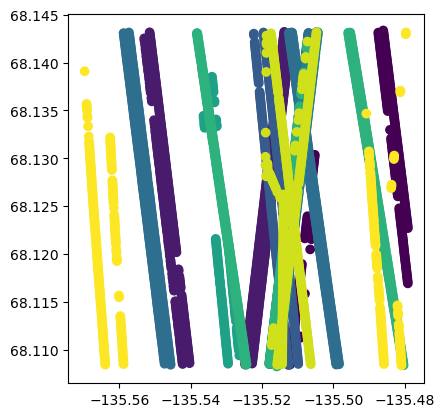

In [4]:
# Take a quick peek to see how many tracks might cross!
gdf.plot(column='cycle')

# Find overlapping points within buffer
Now I'm creating a radius for the points, which involves some reprojection

In [5]:
# A little script I have to get the EPSG string to give to the to_crs function
epsg_string = int(32700-(np.round((45+gdf.geometry.y.values.mean())/90,0)*100)+np.round((183+gdf.geometry.x.values.mean())/6,0))

In [6]:
# Now generate a buffer around each point and make a new dataframe for that 
radius = 7 #radius in meters
gdf_utm = gdf.to_crs(f'EPSG: {epsg_string}')
gdf_crop_poly_geom = gdf_utm.geometry.buffer(radius)
# gdf_crop_poly_geom.to_crs('EPSG:4326').plot()
gdf_crop_poly = gpd.GeoDataFrame(gdf.copy(), geometry=gdf_crop_poly_geom).to_crs('EPSG:4326')
gdf_crop_poly.shape

(5380, 16)

In [7]:
# This is a function that I am pretty sure grabs points that intersect with
# a buffer and calculate the temporal difference between point and buffer
def xover_proc(df):
    #Convert back to point geometry
    df['geometry'] = df.centroid.geometry
    df['dt_diff'] = df['time_left'] - df['time_right']   
    #Remove any self intersections
    idx = (df.index != df['time_right'])
    return df.loc[idx]


In [8]:
# This is new for me! You can do a spatial join on a single geodataframe to find
# the points that intersect with the buffers 
# This creates multiples
xover = gpd.sjoin(
    gdf_crop_poly,
    gdf_crop_poly,
)

In [9]:
# Now calculate the height differences for intersection areas
# Note that there will be pairs of differences - the positive and negatve
# as you subtract an earlier track from a later track and vice versa
xover['h_mean_diff'] = xover['h_mean_left'] - xover['h_mean_right']

# And do the function that gets the temporal difference
# I don't think the centroid error is that important here
xover = xover_proc(xover)


/tmp/ipykernel_640/2390359495.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['geometry'] = df.centroid.geometry


OK so what have we done??

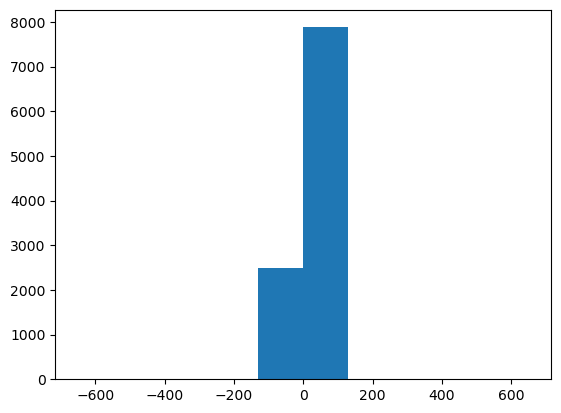

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
data = ax.hist(xover['h_mean_diff'].values)

So there are some huge height differences....seems weird but OK

# Temporal threshold

So the other notebook had the temporal threshold in the opposite direction but I think this is what I want - I want to only look at points whose repeat tracks are from a different cycle

In [11]:
ndays = 30
dt_thresh = pd.Timedelta(days=ndays)
dt_thresh

Timedelta('30 days 00:00:00')

In [12]:
xover_thresh = xover.loc[xover['dt_diff'].abs() > dt_thresh]

In [13]:
# Look at the unique combinations of cycle pairs for the crossovers
xover_thresh.groupby(['cycle_left', 'cycle_right']).size().reset_index().rename(columns={0:'count'})

,cycle_left,cycle_right,count
0,1,5,9
1,1,6,10
2,1,14,5
3,1,15,2
4,2,5,27
5,2,6,6
6,2,10,9
7,2,14,22
8,5,1,9
9,5,2,27


# Map

In [14]:
exploring = gpd.GeoDataFrame(xover_thresh.filter(['h_mean_diff','cycle_left','cycle_right']), geometry=xover_thresh.geometry).to_crs('EPSG:4326')
exploring.explore(column='h_mean_diff')